In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Thu Dec 22 22:54:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    54W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from torchvision import models, datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import shutil
import os
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
%pip install torchinfo
from torchinfo import summary
from sklearn.metrics import f1_score, balanced_accuracy_score, roc_auc_score, precision_score, recall_score
import copy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Raw Data Preprocessing

In [ ]:
!cp /content/drive/MyDrive/ERS/seq_0000.zip .
!unzip seq_0000.zip

In [ ]:
benign_files = glob("seq_0000/benign/*.png")
benign_path = "seq_0000/benign"
benign_dict = {}
malignant_files = glob("seq_0000/malignant/*.png")
malignant_path = "seq_0000/malignant"
malignant_dict = {}

In [ ]:
for f in benign_files:
    k = f.split(benign_path)[-1].split("-")[0].replace("/","")
    if k not in benign_dict: benign_dict[k] = []
    benign_dict[k].append(f)

for f in malignant_files:
    k = f.split(malignant_path)[-1].split("-")[0].replace("/","")
    if k not in malignant_dict: malignant_dict[k] = []
    malignant_dict[k].append(f)

In [ ]:
benign_patients = list(benign_dict.keys())
malignant_patients = list(malignant_dict.keys())
y_benign = [0 for i in range(len(benign_patients))]
y_malignant = [1 for i in range(len(malignant_patients))]

In [ ]:
patients = benign_patients + malignant_patients
y = y_benign + y_malignant

In [ ]:
to_ignore = list(set(benign_patients) & set(malignant_patients))

In [ ]:
patients = [(x, y_value) for (x, y_value) in zip(patients, y) if x not in to_ignore]

In [ ]:
patients, y = zip(*patients)

In [ ]:
np.random.seed(2022)
from sklearn.model_selection import train_test_split
X_train, X_t, y_train, y_t = train_test_split(patients, y, test_size=0.2, shuffle=True)
X_val, X_test, y_val, y_test= train_test_split(X_t, y_t, test_size=0.5, shuffle=True)

In [ ]:
benign_counter = 0
malignant_counter = 0
for key in X_train:
    if key in benign_dict:
        benign_counter += len(benign_dict[key])
    else:
        malignant_counter += len(malignant_dict[key])

In [ ]:
!mkdir processed_data/

In [ ]:
transform = transforms.Compose([
      transforms.Resize((232,232)),
      transforms.CenterCrop((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def save_split(data, benign_dict, malignant_dict, split="train"):
  X = []
  y = []
  counter = 0
  for k in tqdm(data):
    if k in benign_dict:
      for img_path in benign_dict[k]:
        y.append(0)
        img_path = img_path.replace("\\", '/')
        im = Image.open(img_path)
        im = transform(im)
        X.append(im)
    else:
      for img_path in malignant_dict[k]:
        y.append(1)
        img_path = img_path.replace("\\", '/')
        im = Image.open(img_path)
        im = transform(im)
        X.append(im)
  X = torch.stack(X, dim=0).to(torch.float)
  y = torch.FloatTensor(y).unsqueeze(1)
  X_path = f"/content/drive/MyDrive/ERS/X_{split}.pt"
  y_path = f"/content/drive/MyDrive/ERS/y_{split}.pt"
  torch.save(X, X_path)
  torch.save(y, y_path)

In [ ]:
save_split(X_train, benign_dict, malignant_dict, split="train")
save_split(X_val, benign_dict, malignant_dict, split="val")
save_split(X_test, benign_dict, malignant_dict, split="test")

100%|██████████| 34/34 [00:42<00:00,  1.24s/it]


# Data loading and setup

In [ ]:
class ImageDataset(Dataset):
  def __init__(self, data_folder, split="train"):
    self.split = split
    self.x, self.y = self.load()
    print(f"Loaded {split} data... X: {self.x.shape}, y: {self.y.shape}")

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return len(self.x)

  def load(self):
    X_path = f"/content/drive/MyDrive/ERS/X_{self.split}.pt"
    y_path = f"/content/drive/MyDrive/ERS/y_{self.split}.pt"
    return torch.load(X_path), torch.load(y_path)

In [ ]:
X_train = ImageDataset('processed_data', split='train')
X_val = ImageDataset('processed_data', split='val')
X_test = ImageDataset('processed_data', split='test')

Loaded train data... X: torch.Size([13739, 3, 224, 224]), y: torch.Size([13739, 1])
Loaded val data... X: torch.Size([1123, 3, 224, 224]), y: torch.Size([1123, 1])
Loaded test data... X: torch.Size([2149, 3, 224, 224]), y: torch.Size([2149, 1])


In [ ]:
from torch.utils.data import DataLoader
B = 32
train_dataloader = DataLoader(X_train, batch_size=B, shuffle=True)
val_dataloader = DataLoader(X_val, batch_size=256)
test_dataloader = DataLoader(X_test, batch_size=256)

# Verify Input

torch.Size([32, 3, 224, 224])


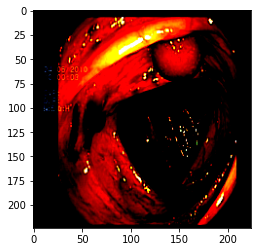

In [ ]:
#visualize dataset with label
for i, example in enumerate(train_dataloader):
    x, y = example
    print(x.shape)
    plt.imshow(x[7].permute((1,2,0)))
    plt.show()
    break

# Model Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_type = "baseline"
#model_type = "pretrained"
experiment = f"exp1_{model_type}"
os.environ["EXP"] = experiment

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.pretrained = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    for param in self.pretrained.parameters():
      param.requires_grad = False
    self.pretrained.layer4 = nn.Identity()
    self.pretrained.avgpool = nn.Sequential(
        nn.Conv2d(1024, 256, (3,3), stride=(2,2)),
        nn.BatchNorm2d(256),
        nn.ReLU(),
    )
    self.pretrained.fc = nn.Sequential(
      nn.Linear(9216, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    x = self.pretrained(x)
    return x

class Baseline(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Conv2d(3, 128, (3,3), stride=(2,2)),
        nn.ReLU(),
        nn.Conv2d(128, 128, (3,3), stride=(2,2)),
        nn.ReLU(),
        nn.Conv2d(128, 32, (3,3), stride=(2,2)),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(23328, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.seq(x)

In [ ]:
model_class = Classifier
if model_type == "baseline": model_class = Baseline
model = model_class().to(device)
summary(model, (B, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
Baseline                                 [32, 1]                   --
├─Sequential: 1-1                        [32, 1]                   --
│    └─Conv2d: 2-1                       [32, 128, 111, 111]       3,584
│    └─ReLU: 2-2                         [32, 128, 111, 111]       --
│    └─Conv2d: 2-3                       [32, 128, 55, 55]         147,584
│    └─ReLU: 2-4                         [32, 128, 55, 55]         --
│    └─Conv2d: 2-5                       [32, 32, 27, 27]          36,896
│    └─ReLU: 2-6                         [32, 32, 27, 27]          --
│    └─Flatten: 2-7                      [32, 23328]               --
│    └─Linear: 2-8                       [32, 1]                   23,329
│    └─Sigmoid: 2-9                      [32, 1]                   --
Total params: 211,393
Trainable params: 211,393
Non-trainable params: 0
Total mult-adds (G): 16.56
Input size (MB): 19.27
Forward/backward 

In [ ]:
!rm -rf runs

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(f"runs/{experiment}")

In [ ]:

loss_fn = nn.BCELoss()
if model_type == "baseline":
  learning_rate = 0.001
  optimizer = optim.Adam(model.parameters(), weight_decay=0.1)
else:
  learning_rate = 0.001
  optimizer = optim.Adam(model.parameters(), weight_decay=0.2)
#lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10)

In [ ]:
n_epochs = 100
best_weights = copy.deepcopy(model.state_dict())
best_loss = float('inf')


for epoch in range(1, n_epochs+1):
  train_loss = 0.0
  training_loss = []
  val_loss = []
  model.train()
  train_pred = []
  train_y = []
  val_pred = []
  val_y = []
  for i, minibatch in tqdm(enumerate(train_dataloader)):
    x, y = minibatch
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    probs = model(x)
    loss = loss_fn(probs,y)
    loss.backward()
    optimizer.step()
    training_loss.append(loss.item())
    preds = (probs > 0.5).to(torch.int)
    train_pred.append(preds.squeeze(1).cpu().numpy())
    train_y.append(y.squeeze(1).to(torch.int).cpu().numpy())

  model.eval()
  for i, minibatch in tqdm(enumerate(val_dataloader)):
    with torch.no_grad():
      x, y = minibatch
      x = x.to(device)
      y = y.to(device)

      probs = model(x)
      loss = loss_fn(probs,y)
      val_loss.append(loss.item())
      preds = (probs > 0.5).to(torch.float)
      val_pred.append(preds.squeeze(1).cpu().numpy())
      val_y.append(y.squeeze(1).to(torch.int).cpu().numpy())

  training_loss = np.mean(training_loss)
  val_loss = np.mean(val_loss)

  total_train_preds = np.concatenate(train_pred, axis=0)
  total_train_y = np.concatenate(train_y, axis=0)

  train_f1 = f1_score(total_train_y, total_train_preds)

  total_val_preds = np.concatenate(val_pred, axis=0)
  total_val_y = np.concatenate(val_y, axis=0)
  val_f1 = f1_score(total_val_y, total_val_preds)

  print(f"Epoch {epoch}")
  print("-"*10)
  print("Train Error: {:.4f}, Train F1: {:.4f}, Val Error: {:.4f}, Val F1: {:.4f}".format(
      training_loss, train_f1, val_loss, val_f1
  ))
  writer.add_scalar("Error/train", training_loss, epoch)
  writer.add_scalar("F1/train", train_f1, epoch)
  writer.add_scalar("Error/val", val_loss, epoch)
  writer.add_scalar("F1/val", val_f1, epoch)

  # Save weights with the best validation loss
  if val_loss < best_loss:
    best_loss = val_loss
    best_weights = copy.deepcopy(model.state_dict())


model.load_state_dict(best_weights)
torch.save(model.state_dict(), f"best_model.pt")
writer.flush()
writer.close()

430it [00:05, 81.15it/s]
5it [00:00, 16.54it/s]


Epoch 1
----------
Train Error: 0.3559, Train F1: 0.3212, Val Error: 0.5880, Val F1: 0.0000


430it [00:05, 81.19it/s]
5it [00:00, 17.93it/s]


Epoch 2
----------
Train Error: 0.2890, Train F1: 0.5287, Val Error: 0.5867, Val F1: 0.0000


430it [00:05, 81.09it/s]
5it [00:00, 18.03it/s]


Epoch 3
----------
Train Error: 0.2788, Train F1: 0.5650, Val Error: 0.9499, Val F1: 0.0000


430it [00:05, 81.16it/s]
5it [00:00, 18.09it/s]


Epoch 4
----------
Train Error: 0.2582, Train F1: 0.6083, Val Error: 0.8964, Val F1: 0.0000


430it [00:05, 81.17it/s]
5it [00:00, 18.17it/s]


Epoch 5
----------
Train Error: 0.2450, Train F1: 0.6347, Val Error: 0.6664, Val F1: 0.0000


430it [00:05, 81.56it/s]
5it [00:00, 18.10it/s]


Epoch 6
----------
Train Error: 0.2437, Train F1: 0.6407, Val Error: 0.7609, Val F1: 0.0000


430it [00:05, 81.55it/s]
5it [00:00, 17.91it/s]


Epoch 7
----------
Train Error: 0.2338, Train F1: 0.6556, Val Error: 0.7447, Val F1: 0.0000


430it [00:05, 81.48it/s]
5it [00:00, 17.96it/s]


Epoch 8
----------
Train Error: 0.2383, Train F1: 0.6447, Val Error: 0.6550, Val F1: 0.0000


430it [00:05, 81.68it/s]
5it [00:00, 17.76it/s]


Epoch 9
----------
Train Error: 0.2285, Train F1: 0.6585, Val Error: 0.8627, Val F1: 0.0000


430it [00:05, 81.18it/s]
5it [00:00, 18.12it/s]


Epoch 10
----------
Train Error: 0.2288, Train F1: 0.6711, Val Error: 0.8606, Val F1: 0.0000


430it [00:05, 81.39it/s]
5it [00:00, 18.09it/s]


Epoch 11
----------
Train Error: 0.2242, Train F1: 0.6711, Val Error: 0.7005, Val F1: 0.0000


430it [00:05, 81.47it/s]
5it [00:00, 18.14it/s]


Epoch 12
----------
Train Error: 0.2302, Train F1: 0.6582, Val Error: 0.8424, Val F1: 0.0000


430it [00:05, 81.52it/s]
5it [00:00, 17.97it/s]


Epoch 13
----------
Train Error: 0.2172, Train F1: 0.6937, Val Error: 0.8432, Val F1: 0.0000


430it [00:05, 81.28it/s]
5it [00:00, 18.12it/s]


Epoch 14
----------
Train Error: 0.2247, Train F1: 0.6792, Val Error: 0.7253, Val F1: 0.0000


430it [00:05, 80.90it/s]
5it [00:00, 17.78it/s]


Epoch 15
----------
Train Error: 0.2194, Train F1: 0.6893, Val Error: 0.6725, Val F1: 0.0000


430it [00:05, 81.43it/s]
5it [00:00, 17.93it/s]


Epoch 16
----------
Train Error: 0.2211, Train F1: 0.6813, Val Error: 0.8180, Val F1: 0.0000


430it [00:05, 81.55it/s]
5it [00:00, 18.05it/s]


Epoch 17
----------
Train Error: 0.2169, Train F1: 0.6889, Val Error: 0.7915, Val F1: 0.0000


430it [00:05, 80.71it/s]
5it [00:00, 17.98it/s]


Epoch 18
----------
Train Error: 0.2107, Train F1: 0.7039, Val Error: 0.6721, Val F1: 0.0000


430it [00:05, 81.66it/s]
5it [00:00, 17.98it/s]


Epoch 19
----------
Train Error: 0.2101, Train F1: 0.7040, Val Error: 0.8775, Val F1: 0.0000


430it [00:05, 81.72it/s]
5it [00:00, 17.80it/s]


Epoch 20
----------
Train Error: 0.2130, Train F1: 0.6888, Val Error: 0.8434, Val F1: 0.0000


430it [00:05, 81.58it/s]
5it [00:00, 17.89it/s]


Epoch 21
----------
Train Error: 0.2155, Train F1: 0.6866, Val Error: 0.8433, Val F1: 0.0000


430it [00:05, 81.43it/s]
5it [00:00, 18.02it/s]


Epoch 22
----------
Train Error: 0.2112, Train F1: 0.7038, Val Error: 0.7358, Val F1: 0.0000


430it [00:05, 81.77it/s]
5it [00:00, 18.04it/s]


Epoch 23
----------
Train Error: 0.2139, Train F1: 0.6965, Val Error: 0.8745, Val F1: 0.0000


430it [00:05, 80.91it/s]
5it [00:00, 17.87it/s]


Epoch 24
----------
Train Error: 0.2129, Train F1: 0.6948, Val Error: 0.8724, Val F1: 0.0000


430it [00:05, 81.47it/s]
5it [00:00, 17.86it/s]


Epoch 25
----------
Train Error: 0.2024, Train F1: 0.7068, Val Error: 0.8213, Val F1: 0.0000


430it [00:05, 81.23it/s]
5it [00:00, 18.05it/s]


Epoch 26
----------
Train Error: 0.2072, Train F1: 0.7053, Val Error: 0.8293, Val F1: 0.0000


430it [00:05, 81.31it/s]
5it [00:00, 17.90it/s]


Epoch 27
----------
Train Error: 0.2113, Train F1: 0.7046, Val Error: 0.9362, Val F1: 0.0184


430it [00:05, 81.68it/s]
5it [00:00, 18.00it/s]


Epoch 28
----------
Train Error: 0.2045, Train F1: 0.7096, Val Error: 0.8095, Val F1: 0.0000


430it [00:05, 81.19it/s]
5it [00:00, 17.92it/s]


Epoch 29
----------
Train Error: 0.2062, Train F1: 0.7118, Val Error: 0.7463, Val F1: 0.0000


430it [00:05, 81.39it/s]
5it [00:00, 17.97it/s]


Epoch 30
----------
Train Error: 0.2064, Train F1: 0.7071, Val Error: 0.7938, Val F1: 0.0000


430it [00:05, 81.55it/s]
5it [00:00, 18.03it/s]


Epoch 31
----------
Train Error: 0.2081, Train F1: 0.7052, Val Error: 0.7664, Val F1: 0.0000


430it [00:05, 81.99it/s]
5it [00:00, 18.15it/s]


Epoch 32
----------
Train Error: 0.2006, Train F1: 0.7206, Val Error: 0.7423, Val F1: 0.0000


430it [00:05, 81.48it/s]
5it [00:00, 17.70it/s]


Epoch 33
----------
Train Error: 0.1946, Train F1: 0.7314, Val Error: 0.8453, Val F1: 0.0000


430it [00:05, 81.77it/s]
5it [00:00, 18.09it/s]


Epoch 34
----------
Train Error: 0.2024, Train F1: 0.7160, Val Error: 0.8766, Val F1: 0.0000


430it [00:05, 80.78it/s]
5it [00:00, 17.93it/s]


Epoch 35
----------
Train Error: 0.1950, Train F1: 0.7239, Val Error: 0.7911, Val F1: 0.0000


430it [00:05, 81.53it/s]
5it [00:00, 17.63it/s]


Epoch 36
----------
Train Error: 0.2019, Train F1: 0.7177, Val Error: 0.7729, Val F1: 0.0000


430it [00:05, 81.07it/s]
5it [00:00, 18.20it/s]


Epoch 37
----------
Train Error: 0.2000, Train F1: 0.7242, Val Error: 0.8301, Val F1: 0.0000


430it [00:05, 81.66it/s]
5it [00:00, 18.22it/s]


Epoch 38
----------
Train Error: 0.2030, Train F1: 0.7152, Val Error: 0.7922, Val F1: 0.0052


430it [00:05, 81.87it/s]
5it [00:00, 17.96it/s]


Epoch 39
----------
Train Error: 0.2060, Train F1: 0.7191, Val Error: 0.7781, Val F1: 0.0000


430it [00:05, 81.41it/s]
5it [00:00, 18.05it/s]


Epoch 40
----------
Train Error: 0.1963, Train F1: 0.7297, Val Error: 0.8003, Val F1: 0.0000


430it [00:05, 81.59it/s]
5it [00:00, 17.58it/s]


Epoch 41
----------
Train Error: 0.2038, Train F1: 0.7214, Val Error: 0.7502, Val F1: 0.0000


430it [00:05, 81.06it/s]
5it [00:00, 18.24it/s]


Epoch 42
----------
Train Error: 0.1943, Train F1: 0.7276, Val Error: 0.7644, Val F1: 0.0000


430it [00:05, 81.48it/s]
5it [00:00, 17.96it/s]


Epoch 43
----------
Train Error: 0.1943, Train F1: 0.7429, Val Error: 0.7899, Val F1: 0.0000


430it [00:05, 81.32it/s]
5it [00:00, 17.98it/s]


Epoch 44
----------
Train Error: 0.1970, Train F1: 0.7241, Val Error: 0.8256, Val F1: 0.0000


430it [00:05, 81.59it/s]
5it [00:00, 17.95it/s]


Epoch 45
----------
Train Error: 0.1984, Train F1: 0.7248, Val Error: 0.9809, Val F1: 0.0000


430it [00:05, 81.33it/s]
5it [00:00, 18.00it/s]


Epoch 46
----------
Train Error: 0.1877, Train F1: 0.7407, Val Error: 0.8888, Val F1: 0.0613


430it [00:05, 81.83it/s]
5it [00:00, 17.89it/s]


Epoch 47
----------
Train Error: 0.1912, Train F1: 0.7376, Val Error: 0.8367, Val F1: 0.0060


430it [00:05, 81.03it/s]
5it [00:00, 18.08it/s]


Epoch 48
----------
Train Error: 0.1857, Train F1: 0.7481, Val Error: 0.8686, Val F1: 0.0000


430it [00:05, 81.17it/s]
5it [00:00, 17.83it/s]


Epoch 49
----------
Train Error: 0.1941, Train F1: 0.7344, Val Error: 0.8776, Val F1: 0.0000


430it [00:05, 81.88it/s]
5it [00:00, 18.01it/s]


Epoch 50
----------
Train Error: 0.1957, Train F1: 0.7285, Val Error: 0.7158, Val F1: 0.0000


430it [00:05, 81.39it/s]
5it [00:00, 17.86it/s]


Epoch 51
----------
Train Error: 0.1872, Train F1: 0.7475, Val Error: 0.8901, Val F1: 0.0000


430it [00:05, 81.31it/s]
5it [00:00, 17.79it/s]


Epoch 52
----------
Train Error: 0.1775, Train F1: 0.7595, Val Error: 0.8550, Val F1: 0.0000


430it [00:05, 81.76it/s]
5it [00:00, 18.06it/s]


Epoch 53
----------
Train Error: 0.1928, Train F1: 0.7340, Val Error: 0.6935, Val F1: 0.0000


430it [00:05, 81.57it/s]
5it [00:00, 18.10it/s]


Epoch 54
----------
Train Error: 0.1851, Train F1: 0.7451, Val Error: 0.8754, Val F1: 0.0693


430it [00:05, 81.46it/s]
5it [00:00, 17.99it/s]


Epoch 55
----------
Train Error: 0.1776, Train F1: 0.7584, Val Error: 0.7357, Val F1: 0.0000


430it [00:05, 80.81it/s]
5it [00:00, 17.78it/s]


Epoch 56
----------
Train Error: 0.1810, Train F1: 0.7557, Val Error: 0.7556, Val F1: 0.0000


430it [00:05, 80.87it/s]
5it [00:00, 17.83it/s]


Epoch 57
----------
Train Error: 0.1751, Train F1: 0.7687, Val Error: 0.7692, Val F1: 0.0000


430it [00:05, 81.37it/s]
5it [00:00, 17.69it/s]


Epoch 58
----------
Train Error: 0.1878, Train F1: 0.7469, Val Error: 0.8262, Val F1: 0.0000


430it [00:05, 81.13it/s]
5it [00:00, 18.12it/s]


Epoch 59
----------
Train Error: 0.1811, Train F1: 0.7548, Val Error: 0.7806, Val F1: 0.0000


430it [00:05, 81.22it/s]
5it [00:00, 17.99it/s]


Epoch 60
----------
Train Error: 0.1753, Train F1: 0.7706, Val Error: 0.7775, Val F1: 0.0000


430it [00:05, 81.19it/s]
5it [00:00, 18.20it/s]


Epoch 61
----------
Train Error: 0.1806, Train F1: 0.7538, Val Error: 0.8764, Val F1: 0.0000


430it [00:05, 81.80it/s]
5it [00:00, 18.02it/s]


Epoch 62
----------
Train Error: 0.1760, Train F1: 0.7621, Val Error: 0.7760, Val F1: 0.0000


430it [00:05, 81.61it/s]
5it [00:00, 18.25it/s]


Epoch 63
----------
Train Error: 0.1757, Train F1: 0.7659, Val Error: 0.9035, Val F1: 0.0000


430it [00:05, 81.74it/s]
5it [00:00, 18.08it/s]


Epoch 64
----------
Train Error: 0.1757, Train F1: 0.7635, Val Error: 0.7627, Val F1: 0.0000


430it [00:05, 80.97it/s]
5it [00:00, 17.87it/s]


Epoch 65
----------
Train Error: 0.1762, Train F1: 0.7561, Val Error: 0.8287, Val F1: 0.0000


430it [00:05, 81.55it/s]
5it [00:00, 11.12it/s]


Epoch 66
----------
Train Error: 0.1756, Train F1: 0.7607, Val Error: 0.7494, Val F1: 0.0000


430it [00:05, 80.84it/s]
5it [00:00, 17.85it/s]


Epoch 67
----------
Train Error: 0.1781, Train F1: 0.7626, Val Error: 0.7679, Val F1: 0.0000


430it [00:05, 81.43it/s]
5it [00:00, 17.85it/s]


Epoch 68
----------
Train Error: 0.1759, Train F1: 0.7651, Val Error: 0.7976, Val F1: 0.0000


430it [00:05, 81.17it/s]
5it [00:00, 18.10it/s]


Epoch 69
----------
Train Error: 0.1753, Train F1: 0.7649, Val Error: 0.7806, Val F1: 0.0000


430it [00:05, 81.53it/s]
5it [00:00, 17.90it/s]


Epoch 70
----------
Train Error: 0.1713, Train F1: 0.7725, Val Error: 0.8081, Val F1: 0.0255


430it [00:05, 81.31it/s]
5it [00:00, 17.99it/s]


Epoch 71
----------
Train Error: 0.1747, Train F1: 0.7701, Val Error: 0.8853, Val F1: 0.0000


430it [00:05, 81.54it/s]
5it [00:00, 17.93it/s]


Epoch 72
----------
Train Error: 0.1725, Train F1: 0.7726, Val Error: 0.9898, Val F1: 0.0168


430it [00:05, 81.63it/s]
5it [00:00, 18.36it/s]


Epoch 73
----------
Train Error: 0.1752, Train F1: 0.7632, Val Error: 0.7735, Val F1: 0.0055


430it [00:05, 81.14it/s]
5it [00:00, 18.15it/s]


Epoch 74
----------
Train Error: 0.1658, Train F1: 0.7847, Val Error: 0.7342, Val F1: 0.0000


430it [00:05, 81.19it/s]
5it [00:00, 17.93it/s]


Epoch 75
----------
Train Error: 0.1733, Train F1: 0.7748, Val Error: 0.7440, Val F1: 0.0086


430it [00:05, 81.25it/s]
5it [00:00, 17.69it/s]


Epoch 76
----------
Train Error: 0.1758, Train F1: 0.7587, Val Error: 0.7562, Val F1: 0.0124


430it [00:05, 81.47it/s]
5it [00:00, 18.13it/s]


Epoch 77
----------
Train Error: 0.1683, Train F1: 0.7820, Val Error: 0.8099, Val F1: 0.0000


430it [00:05, 80.82it/s]
5it [00:00, 18.02it/s]


Epoch 78
----------
Train Error: 0.1607, Train F1: 0.7992, Val Error: 0.8332, Val F1: 0.0418


430it [00:05, 81.59it/s]
5it [00:00, 18.10it/s]


Epoch 79
----------
Train Error: 0.1643, Train F1: 0.7855, Val Error: 0.8414, Val F1: 0.0000


430it [00:05, 81.07it/s]
5it [00:00, 18.10it/s]


Epoch 80
----------
Train Error: 0.1676, Train F1: 0.7872, Val Error: 0.8503, Val F1: 0.0000


430it [00:05, 81.63it/s]
5it [00:00, 18.10it/s]


Epoch 81
----------
Train Error: 0.1675, Train F1: 0.7875, Val Error: 0.8109, Val F1: 0.0000


430it [00:05, 81.47it/s]
5it [00:00, 18.05it/s]


Epoch 82
----------
Train Error: 0.1574, Train F1: 0.7998, Val Error: 0.7105, Val F1: 0.0095


430it [00:05, 82.10it/s]
5it [00:00, 18.08it/s]


Epoch 83
----------
Train Error: 0.1579, Train F1: 0.7952, Val Error: 0.8508, Val F1: 0.0000


430it [00:05, 81.60it/s]
5it [00:00, 18.05it/s]


Epoch 84
----------
Train Error: 0.1631, Train F1: 0.7893, Val Error: 0.7739, Val F1: 0.0579


430it [00:05, 81.75it/s]
5it [00:00, 17.96it/s]


Epoch 85
----------
Train Error: 0.1555, Train F1: 0.8080, Val Error: 0.7908, Val F1: 0.0000


430it [00:05, 81.92it/s]
5it [00:00, 17.69it/s]


Epoch 86
----------
Train Error: 0.1530, Train F1: 0.8090, Val Error: 0.6423, Val F1: 0.0000


430it [00:05, 81.10it/s]
5it [00:00, 17.89it/s]


Epoch 87
----------
Train Error: 0.1540, Train F1: 0.8080, Val Error: 0.7016, Val F1: 0.1364


430it [00:05, 81.54it/s]
5it [00:00, 17.75it/s]


Epoch 88
----------
Train Error: 0.1513, Train F1: 0.8135, Val Error: 0.6992, Val F1: 0.0000


430it [00:05, 80.49it/s]
5it [00:00, 17.89it/s]


Epoch 89
----------
Train Error: 0.1542, Train F1: 0.8052, Val Error: 0.6929, Val F1: 0.0562


430it [00:05, 81.21it/s]
5it [00:00, 17.76it/s]


Epoch 90
----------
Train Error: 0.1458, Train F1: 0.8146, Val Error: 0.7408, Val F1: 0.1405


430it [00:05, 81.11it/s]
5it [00:00, 18.20it/s]


Epoch 91
----------
Train Error: 0.1501, Train F1: 0.8088, Val Error: 0.6582, Val F1: 0.0949


430it [00:05, 81.99it/s]
5it [00:00, 18.07it/s]


Epoch 92
----------
Train Error: 0.1484, Train F1: 0.8145, Val Error: 0.6882, Val F1: 0.1720


430it [00:05, 80.45it/s]
5it [00:00, 17.41it/s]


Epoch 93
----------
Train Error: 0.1524, Train F1: 0.8119, Val Error: 0.6843, Val F1: 0.0114


430it [00:05, 80.89it/s]
5it [00:00, 17.95it/s]


Epoch 94
----------
Train Error: 0.1539, Train F1: 0.8092, Val Error: 0.8200, Val F1: 0.0097


430it [00:05, 81.46it/s]
5it [00:00, 17.74it/s]


Epoch 95
----------
Train Error: 0.1533, Train F1: 0.8087, Val Error: 0.6699, Val F1: 0.1364


430it [00:05, 81.50it/s]
5it [00:00, 18.15it/s]


Epoch 96
----------
Train Error: 0.1525, Train F1: 0.8077, Val Error: 0.6701, Val F1: 0.0905


430it [00:05, 81.09it/s]
5it [00:00, 17.72it/s]


Epoch 97
----------
Train Error: 0.1457, Train F1: 0.8214, Val Error: 0.6450, Val F1: 0.0117


430it [00:05, 81.69it/s]
5it [00:00, 18.05it/s]


Epoch 98
----------
Train Error: 0.1593, Train F1: 0.7905, Val Error: 0.7847, Val F1: 0.0000


430it [00:05, 81.12it/s]
5it [00:00, 17.74it/s]


Epoch 99
----------
Train Error: 0.1525, Train F1: 0.8108, Val Error: 0.5544, Val F1: 0.1834


430it [00:05, 81.62it/s]
5it [00:00, 17.67it/s]

Epoch 100
----------
Train Error: 0.1437, Train F1: 0.8250, Val Error: 0.6112, Val F1: 0.1043


In [ ]:
!cp -r runs/${EXP} /content/drive/MyDrive/ERS/runs/
!cp best_model.pt /content/drive/MyDrive/ERS/runs/${EXP}/best_model.pt

In [ ]:
model = model_class().to(device)
model.load_state_dict(torch.load(f"/content/drive/MyDrive/ERS/runs/{experiment}/best_model.pt"))
model.eval()

test_pred = []
test_y = []
test_loss = []
test_probs = []
for i, minibatch in tqdm(enumerate(test_dataloader)):
  with torch.no_grad():
    x, y = minibatch
    x = x.to(device)
    y = y.to(device)

    probs = model(x)
    loss = loss_fn(probs,y)
    test_loss.append(loss.item())
    preds = (probs > 0.5).to(torch.float)
    test_probs.append(probs.squeeze(1).cpu().numpy())
    test_pred.append(preds.squeeze(1).cpu().numpy())
    test_y.append(y.squeeze(1).to(torch.int).cpu().numpy())

test_err = np.mean(test_loss)

total_test_preds = np.concatenate(test_pred, axis=0)
total_test_y = np.concatenate(test_y, axis=0)
total_test_probs = np.concatenate(test_probs, axis=0)

test_f1 = f1_score(total_test_y, total_test_preds)
test_acc = balanced_accuracy_score(total_test_y, total_test_preds)
test_auroc = roc_auc_score(total_test_y, total_test_probs)
test_precision = precision_score(total_test_y, total_test_preds)
test_recall = recall_score(total_test_y, total_test_preds)

print("Test Error: {:.4f}, Test F1: {:.4f}, Test Acc: {:.4f}, Test AUROC: {:.4f}, Test Precision: {:.4f}, Test Recall: {:.4f}".format(
    test_err, test_f1, test_acc, test_auroc, test_precision, test_recall
))

test_results = {
    "Test Error": test_err,
    "Test F1": test_f1,
    "Test Acc": test_acc,
    "Test AUROC": test_auroc,
    "Test Precision": test_precision,
    "Test Recall": test_recall
}

import json
with open(f"/content/drive/MyDrive/ERS/runs/{experiment}/test_results.json", "w") as f:
  json.dump(test_results, f)


9it [00:00, 16.12it/s]

Test Error: 0.6324, Test F1: 0.2664, Test Acc: 0.5230, Test AUROC: 0.6307, Test Precision: 0.2895, Test Recall: 0.2467
